## **1. Imports**

In [1]:
import numpy as np
import pandas as pd

import lightgbm as lgb
from sklearn.cluster import KMeans
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_percentage_error

from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer

import re
import warnings
from pathlib import Path

import wandb

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme()
warnings.filterwarnings('ignore')

In [2]:
# Config

pd.set_option('display.max_columns', None)

ROOT = Path("/kaggle/input/rohlik-orders-forecasting-challenge")
SEED = 42
FOLDS = 10

In [3]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("wandb.api.key")

wandb.login(key=secret_value_0)

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

## **2. Data**

In [4]:
df_train = pd.read_csv(
    ROOT / "train.csv",
    parse_dates=["date"],
).drop("id", axis=1)

In [5]:
df_test = pd.read_csv(
    ROOT / "test.csv",
    parse_dates=["date"],
).drop("id", axis=1)

In [6]:
non_test_cols = set(df_train.columns).difference(set(df_test.columns))
non_test_cols.discard("orders")

print(non_test_cols)

{'snow', 'mini_shutdown', 'user_activity_2', 'user_activity_1', 'mov_change', 'blackout', 'precipitation', 'frankfurt_shutdown', 'shutdown'}


## **3. Feature Engineering**

**cluster**

In [7]:
kmeans = KMeans(n_clusters=3, random_state=SEED) 

df_train['cluster'] = kmeans.fit_predict(df_train[['holiday', 'school_holidays','winter_school_holidays']])
df_test['cluster'] = kmeans.predict(df_test[['holiday', 'school_holidays','winter_school_holidays']])

**date features**

In [8]:
def consecutive_days(df_train, df_test):
    mapping_days = {
        d: i for i, d in enumerate(
            pd.date_range(start=df_train["date"].min(), end=df_test["date"].max(), freq="D")
        )}
    df_train["cons_day"] = df_train["date"].map(mapping_days)
    df_test["cons_day"] = df_test["date"].map(mapping_days)
    return df_train, df_test

def consecutive_weeks(df_train, df_test):
    df_all = pd.concat([df_train, df_test], axis=0)

    mapping_train_weeks = {
        w: i for i, w in enumerate(
            (df_all["date"].dt.year*100 + df_all["date"].dt.isocalendar().week).unique()
        )} 

    df_train["cons_week"] = (df_train["date"].dt.year*100 + df_train["date"].dt.isocalendar().week).map(mapping_train_weeks)
    df_test["cons_week"] = (df_test["date"].dt.year*100 + df_test["date"].dt.isocalendar().week).map(mapping_train_weeks)
    return df_train, df_test

# def consecutive_months(df_train, df_test):
#     mapping_months = {
#         d: i for i, d in enumerate(
#             pd.date_range(start=df_train["date"].min(), end=df_test["date"].max(), freq="M")
#         )}
#     df_train["cons_month"] = (df_train["date"] + pd.offsets.MonthEnd(0)).map(mapping_months)
#     df_test["cons_month"] = (df_test["date"] + pd.offsets.MonthEnd(0)).map(mapping_months)
#     return df_train, df_test

In [9]:
df_train, df_test = consecutive_days(df_train, df_test)
df_train, df_test = consecutive_weeks(df_train, df_test)
# df_train, df_test = consecutive_months(df_train, df_test)

In [10]:
def date_feats(df):
    df["day"] = df["date"].dt.day
    df["month"] = df["date"].dt.month
    df["year"] = df["date"].dt.year
    df["dayofweek"] = df["date"].dt.dayofweek
    df["dayofyear"] = df["date"].dt.dayofyear
    df["weekofyear"] = df["date"].dt.isocalendar().week
    df["quarter"] = df["date"].dt.quarter
#     df["is_weekend"] = df["dayofweek"].isin([5, 6]).astype(int)
#     df["is_month_start"] = df["date"].dt.is_month_start
#     df["is_month_end"] = df["date"].dt.is_month_end
#     df["is_quarter_start"] = df["date"].dt.is_quarter_start
    df["is_quarter_end"] = df["date"].dt.is_quarter_end
#     df["is_year_start"] = df["date"].dt.is_year_start
#     df["is_year_end"] = df["date"].dt.is_year_end

    df['total_holidays_month'] = df.groupby(['year', 'month'])['holiday'].transform('sum')
    return df.drop(["date"], axis=1)


df_train = date_feats(df_train)
df_test = date_feats(df_test)

In [11]:
def shop_intense_days(data):
    
    black_friday = ((data['day'] >= 22) & (data['day'] <= 28) & (data['month'] == 11) & (data['weekofyear'] == 4))
    cyber_monday = ((data['day'] >= 22) & (data['day'] <= 28) & (data['month'] == 11) & (data['weekofyear'] == 0))
    valentines_day = ((data['day'] == 14) & (data['month'] == 2))
    singles_day = ((data['day'] == 11) & (data['month'] == 11))
    christmas_eve = ((data['day'] == 24) & (data['month'] == 12))
    christmas_day = ((data['day'] == 25) & (data['month'] == 12))
    new_years_eve = ((data['day'] == 31) & (data['month'] == 12))
    new_years_day = ((data['day'] == 1) & (data['month'] == 1))
    boxing_day = ((data['day'] == 26) & (data['month'] == 12))
    easter_monday = ((data['day'] == 1) & (data['month'] == 4))  # placeholder
    summer_sales = (data['month'].isin([7, 8]))
    winter_sales = ((data['month'] == 1) | ((data['day'] >= 27) & (data['month'] == 12)))
    prime_day = ((data['day'] == 15) & (data['month'] == 7))  # placeholder
    green_monday = ((data['day'] >= 8) & (data['day'] <= 14) & (data['month'] == 12) & (data['weekofyear'] == 0))
    click_frenzy = (((data['day'] == 15) & (data['month'] == 5)) | ((data['day'] == 15) & (data['month'] == 11)))  # placeholder
    # Orthodox Christian events (using placeholder dates - these need to be adjusted yearly)
    orthodox_christmas = ((data['day'] == 7) & (data['month'] == 1))
    orthodox_new_year = ((data['day'] == 14) & (data['month'] == 1))
    orthodox_easter = ((data['day'] == 15) & (data['month'] == 4))  # placeholder
    orthodox_easter_monday = ((data['day'] == 16) & (data['month'] == 4))  # placeholder
    orthodox_pentecost = ((data['day'] == 3) & (data['month'] == 6))  # placeholder
    dormition_of_theotokos = ((data['day'] == 15) & (data['month'] == 8))
    nativity_of_theotokos = ((data['day'] == 8) & (data['month'] == 9))
    exaltation_of_the_cross = ((data['day'] == 14) & (data['month'] == 9))

    # # New dates added
    october_first = ((data['day'] == 1) & (data['month'] == 10))
    april_sixteenth = ((data['day'] == 16) & (data['month'] == 4))
    december_twenty_second = ((data['day'] == 22) & (data['month'] == 12))
    april_sixth = ((data['day'] == 6) & (data['month'] == 4))

    # Sum up all the boolean masks
    data['shopping_intensity'] = (
        black_friday.astype(int) +
        cyber_monday.astype(int) +
        valentines_day.astype(int) +
        singles_day.astype(int) +
        christmas_eve.astype(int) +
        christmas_day.astype(int) +
        new_years_eve.astype(int) +
        new_years_day.astype(int) +
        boxing_day.astype(int) +
        easter_monday.astype(int) +
        summer_sales.astype(int) +
        winter_sales.astype(int) +
        prime_day.astype(int) +
        green_monday.astype(int) +
        click_frenzy.astype(int) +
        # Orthodox events
        orthodox_christmas.astype(int) +
        orthodox_new_year.astype(int) +
        orthodox_easter.astype(int) +
        orthodox_easter_monday.astype(int) +
        orthodox_pentecost.astype(int) +
        dormition_of_theotokos.astype(int) +
        nativity_of_theotokos.astype(int) +
        exaltation_of_the_cross.astype(int)+
        # New dates added
        october_first.astype(int) +
        april_sixteenth.astype(int) +
        december_twenty_second.astype(int) +
        april_sixth.astype(int)
    )
    # # Create a boolean column for any shopping day
#     data['is_shopping_day'] = data['shopping_intensity'] > 0
    return data


df_train = shop_intense_days(df_train)
df_test = shop_intense_days(df_test)

In [12]:
def create_sin_cos(df, var, t):
    df[f"{var}_sin"] = np.sin(2 * np.pi * df[var] / t)
    df[f"{var}_cos"] = np.cos(2 * np.pi * df[var] / t)
    return df.drop(var, axis=1)
    
def ciclic_feats(df, mapping=None):
    if mapping== None:
        mapping = {
            "month": 12,
            "dayofyear": 365,
            "day": 31,
            "weekofyear": 52,
            "dayofweek": 7,
            "quarter": 4,
        }

    for var, t in mapping.items():
        df = create_sin_cos(df, var, t)
    
    return df


df_train = ciclic_feats(df_train)
df_test = ciclic_feats(df_test)

**holidays**

In [13]:
def transform_ohe(ohe, df, var):
    ohe_encoded = pd.DataFrame(
        ohe.transform(df[[var]]), 
        columns=ohe.get_feature_names_out([var])
    )
    return pd.concat([df, ohe_encoded], axis=1).drop(var, axis=1)

In [14]:
holidays = list(df_train["holiday_name"].unique())
holidays.remove(np.nan)

hol_ohe = OneHotEncoder(
    categories=[holidays],
    drop=None,
    sparse_output=False,
    handle_unknown="ignore",
)
hol_ohe.fit(df_train[["holiday_name"]])

df_train = transform_ohe(hol_ohe, df_train, "holiday_name")
df_test = transform_ohe(hol_ohe, df_test, "holiday_name")

In [15]:
# holiday before & after

def create_proximity_hols(df):
    df['holiday_before'] = df['holiday'].shift(1).fillna(0).astype(int)
    df['holiday_after'] = df['holiday'].shift(-1).fillna(0).astype(int)
    return df

df_train = create_proximity_hols(df_train)
df_test = create_proximity_hols(df_test)


def create_diff_hols(df_train, df_test):
    diff_cols = [c for c in df_train.columns if c not in df_test.columns]
    df_all = pd.concat([df_train, df_test], axis=0)
    
    for lag in [3, 7, 14]:
        df_all[f"holiday_lag_diff_{lag}"] = df_all.groupby('warehouse')['holiday'].diff(lag).fillna(0).astype(int)
#         df_all[f"school_holidays_lag_diff_{lag}"] = df_all.groupby('warehouse')['school_holidays'].diff(lag).fillna(0).astype(int)
    
    df_train = df_all[df_all["orders"].notnull()]
    df_test = df_all.loc[df_all["orders"].isnull()].drop(diff_cols, axis=1)
    
    return df_train, df_test

df_train, df_test = create_diff_hols(df_train, df_test)

**warehouse**

In [16]:
# Dictionary mapping cities to their countries

def city2country(df, skip_hungary=True):
    df["germany"] = np.where(df["warehouse"].isin(["Munich_1", "Frankfurt_1"]), 1, 0)
    df["czech"] = np.where(df["warehouse"].isin(["Brno_1", "Prague_1", "Prague_2", "Prague_3"]), 1, 0)
    if skip_hungary is not True:
        df["hungary"] = np.where(df["warehouse"]=="Budapest_1", 1, 0)
    return df

df_train = city2country(df_train)
df_test = city2country(df_test)

In [17]:
# OHE warehouse

warehouses = list(df_train["warehouse"].unique())

wh_ohe = OneHotEncoder(
    categories=[warehouses],
    drop=None,
    sparse_output=False,
    handle_unknown="ignore",
)
wh_ohe.fit(df_train[["warehouse"]])

df_train = transform_ohe(wh_ohe, df_train, "warehouse")
df_test = transform_ohe(wh_ohe, df_test, "warehouse")


# wh_le = LabelEncoder()
# df_train["warehouse"] = wh_le.fit_transform(df_train["warehouse"])
# df_test["warehouse"] = wh_le.transform(df_test["warehouse"])

## **4. Feature Selection**

In [18]:
df_train[list(non_test_cols)].head()

,snow,mini_shutdown,user_activity_2,user_activity_1,mov_change,blackout,precipitation,frankfurt_shutdown,shutdown
0,0.0,0.0,32575.0,1722.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,32507.0,1688.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,32552.0,1696.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,32423.0,1681.0,0.0,0.0,0.8,0.0,0.0
4,0.0,0.0,32410.0,1704.0,0.0,0.0,0.5,0.0,0.0


In [19]:
cols_2_delete = ["snow", "precipitation", "user_activity_1", "user_activity_2", "mov_change"]

df_train = df_train.drop(cols_2_delete, axis=1)

In [20]:
print(f"Rows before: {df_train.shape[0]}")

other_cols = [c for c in non_test_cols if c not in cols_2_delete]
print(other_cols)

for c in other_cols:
    df_train = df_train[df_train[c] == 0]

df_train = df_train.drop(other_cols, axis=1)

print(f"Rows after: {df_train.shape[0]}")

Rows before: 7340
['mini_shutdown', 'blackout', 'frankfurt_shutdown', 'shutdown']
Rows after: 7326


In [21]:
df_train.head()

,orders,holiday,shops_closed,winter_school_holidays,school_holidays,cluster,cons_day,cons_week,year,is_quarter_end,total_holidays_month,shopping_intensity,month_sin,month_cos,dayofyear_sin,dayofyear_cos,day_sin,day_cos,weekofyear_sin,weekofyear_cos,dayofweek_sin,dayofweek_cos,quarter_sin,quarter_cos,holiday_name_Christmas Eve,holiday_name_2nd Christmas Day,holiday_name_New Years Day,holiday_name_International womens day,holiday_name_Good Friday,holiday_name_Easter Monday,holiday_name_Labour Day,holiday_name_Den osvobozeni,holiday_name_Cyrila a Metodej,holiday_name_Jan Hus,holiday_name_Den ceske statnosti,holiday_name_Den vzniku samostatneho ceskoslovenskeho statu,holiday_name_Den boje za svobodu a demokracii,holiday_name_Peace Festival in Augsburg,holiday_name_Reformation Day,holiday_name_Memorial Day of the Republic,holiday_name_Memorial Day for the Victims of the Communist Dictatorships,holiday_name_Memorial Day for the Victims of the Holocaust,holiday_name_National Defense Day,holiday_name_Day of National Unity,holiday_name_Independent Hungary Day,holiday_name_Memorial Day for the Martyrs of Arad,holiday_name_1848 Revolution Memorial Day (Extra holiday),holiday_name_All Saints' Day Holiday,holiday_before,holiday_after,holiday_lag_diff_3,holiday_lag_diff_7,holiday_lag_diff_14,germany,czech,warehouse_Prague_1,warehouse_Brno_1,warehouse_Prague_2,warehouse_Prague_3,warehouse_Munich_1,warehouse_Frankfurt_1,warehouse_Budapest_1
0,6895.0,0,0,0,0,0,0,0,2020,False,9,0,-2.449294e-16,1.0,-0.417194,0.908818,0.848644,0.528964,-0.354605,0.935016,-0.974928,-0.222521,-2.449294e-16,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,6584.0,0,0,0,0,0,1,0,2020,False,9,0,-2.449294e-16,1.0,-0.401488,0.915864,0.937752,0.347305,-0.354605,0.935016,-0.781831,0.623490,-2.449294e-16,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,7030.0,0,0,0,0,0,2,1,2020,False,9,0,-2.449294e-16,1.0,-0.385663,0.922640,0.988468,0.151428,-0.239316,0.970942,0.000000,1.000000,-2.449294e-16,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,6550.0,0,0,0,0,0,3,1,2020,False,9,0,-2.449294e-16,1.0,-0.369725,0.929141,0.998717,-0.050649,-0.239316,0.970942,0.781831,0.623490,-2.449294e-16,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,6910.0,0,0,0,0,0,4,1,2020,False,9,0,-2.449294e-16,1.0,-0.353676,0.935368,0.968077,-0.250653,-0.239316,0.970942,0.974928,-0.222521,-2.449294e-16,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
df_test.head()

,holiday,shops_closed,winter_school_holidays,school_holidays,cluster,cons_day,cons_week,year,is_quarter_end,total_holidays_month,shopping_intensity,month_sin,month_cos,dayofyear_sin,dayofyear_cos,day_sin,day_cos,weekofyear_sin,weekofyear_cos,dayofweek_sin,dayofweek_cos,quarter_sin,quarter_cos,holiday_name_Christmas Eve,holiday_name_2nd Christmas Day,holiday_name_New Years Day,holiday_name_International womens day,holiday_name_Good Friday,holiday_name_Easter Monday,holiday_name_Labour Day,holiday_name_Den osvobozeni,holiday_name_Cyrila a Metodej,holiday_name_Jan Hus,holiday_name_Den ceske statnosti,holiday_name_Den vzniku samostatneho ceskoslovenskeho statu,holiday_name_Den boje za svobodu a demokracii,holiday_name_Peace Festival in Augsburg,holiday_name_Reformation Day,holiday_name_Memorial Day of the Republic,holiday_name_Memorial Day for the Victims of the Communist Dictatorships,holiday_name_Memorial Day for the Victims of the Holocaust,holiday_name_National Defense Day,holiday_name_Day of National Unity,holiday_name_Independent Hungary Day,holiday_name_Memorial Day for the Martyrs of Arad,holiday_name_1848 Revolution Memorial Day (Extra holiday),holiday_name_All Saints' Day Holiday,holiday_before,holiday_after,holiday_lag_diff_3,holiday_lag_diff_7,holiday_lag_diff_14,germany,czech,warehouse_Prague_1,warehouse_Brno_1,warehouse_Prague_2,warehouse_Prague_3,warehouse_Munich_1,warehouse_Frankfurt_1,warehouse_Budapest_1
0,0,0,0,0,0,1197,172,2024,False,15,0,1.0,6.123234e-17,0.965740,0.259512,-0.101168,-0.994869,0.970942,0.239316,-0.974928,-0.222521,1.0,6.123234e-17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0,0,0,0,1198,172,2024,False,15,0,1.0,6.123234e-17,0.970064,0.242850,-0.299363,-0.954139,0.970942,0.239316,-0.781831,0.623490,1.0,6.123234e-17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0,0,0,0,1199,173,2024,False,15,0,1.0,6.123234e-17,0.974100,0.226116,-0.485302,-0.874347,0.992709,0.120537,0.000000,1.000000,1.0,6.123234e-17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0,0,0,0,1200,173,2024,False,15,0,1.0,6.123234e-17,0.977848,0.209315,-0.651372,-0.758758,0.992709,0.120537,0.781831,0.623490,1.0,6.123234e-17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0,0,0,0,1201,173,2024,False,15,0,1.0,6.123234e-17,0.981306,0.192452,-0.790776,-0.612106,0.992709,0.120537,0.974928,-0.222521,1.0,6.123234e-17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
# Columns Integrity

print("Cols in train not in test: {}".format(set(df_train.columns).difference(set(df_test.columns))))
print("Cols in test not in train: {}".format(set(df_test.columns).difference(set(df_train.columns))))

Cols in train not in test: {'orders'}
Cols in test not in train: set()


In [24]:
# Nulls

nulls = (df_train.isnull()).sum()
print(nulls[nulls > 0])

nulls = (df_test.isnull()).sum()
print(nulls[nulls > 0])

Series([], dtype: int64)
Series([], dtype: int64)


In [25]:
# Cols names

df_train.columns = [re.sub(" ", "_", c) for c in df_train.columns]
df_test.columns = [re.sub(" ", "_", c) for c in df_test.columns]

## **5. Model**

In [26]:
# cutoff = 2023
# df_train = df_train[df_train["year"] >= cutoff]

In [27]:
cv = GroupKFold(FOLDS)
cv_group = df_train["cons_week"].astype("str")

In [28]:
params = {
    "objective": "regression",
    "metric": "mape",
    'boosting_type': 'gbdt',
    "n_estimators": 6000,
    
    'random_state': SEED,
    'verbosity': -1,
    'n_jobs': -1,
}

In [29]:
# Run description

run_notes = """
    + shop_intense_days
"""

run = wandb.init(
    project = 'rohlik-orders',
    config = params,
    save_code = True,
    group = 'cv_model-lgbm',
    notes = run_notes,
)

wandb: Currently logged in as: diegoib. Use `wandb login --relogin` to force relogin
wandb: wandb version 0.17.5 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.4
wandb: Run data is saved locally in /kaggle/working/wandb/run-20240803_142613-2ot1eu7w
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run sleek-wind-116
wandb: ⭐️ View project at https://wandb.ai/diegoib/rohlik-orders
wandb: 🚀 View run at https://wandb.ai/diegoib/rohlik-orders/runs/2ot1eu7w


In [30]:
label = df_train.pop("orders")

In [31]:
fitted_models = []
scores = []
oof = np.zeros(df_train.shape[0])

for idx_train, idx_valid in cv.split(df_train, groups=cv_group):
    
    X_train, y_train = df_train.iloc[idx_train], label.iloc[idx_train]
    X_valid, y_valid = df_train.iloc[idx_valid], label.iloc[idx_valid]
    
    model = lgb.LGBMRegressor(**params)
    model.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        callbacks=[lgb.early_stopping(100)]
    )
    
    preds = model.predict(X_valid)
    oof[idx_valid] = preds
    scores.append(mean_absolute_percentage_error(y_valid, preds))
    fitted_models.append(model)    

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[218]	valid_0's mape: 0.0487939
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[329]	valid_0's mape: 0.0404113
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[377]	valid_0's mape: 0.0426261
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[490]	valid_0's mape: 0.0375187
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[173]	valid_0's mape: 0.0378393
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[289]	valid_0's mape: 0.0393025
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[441]	valid_0's mape: 0.0385883
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:


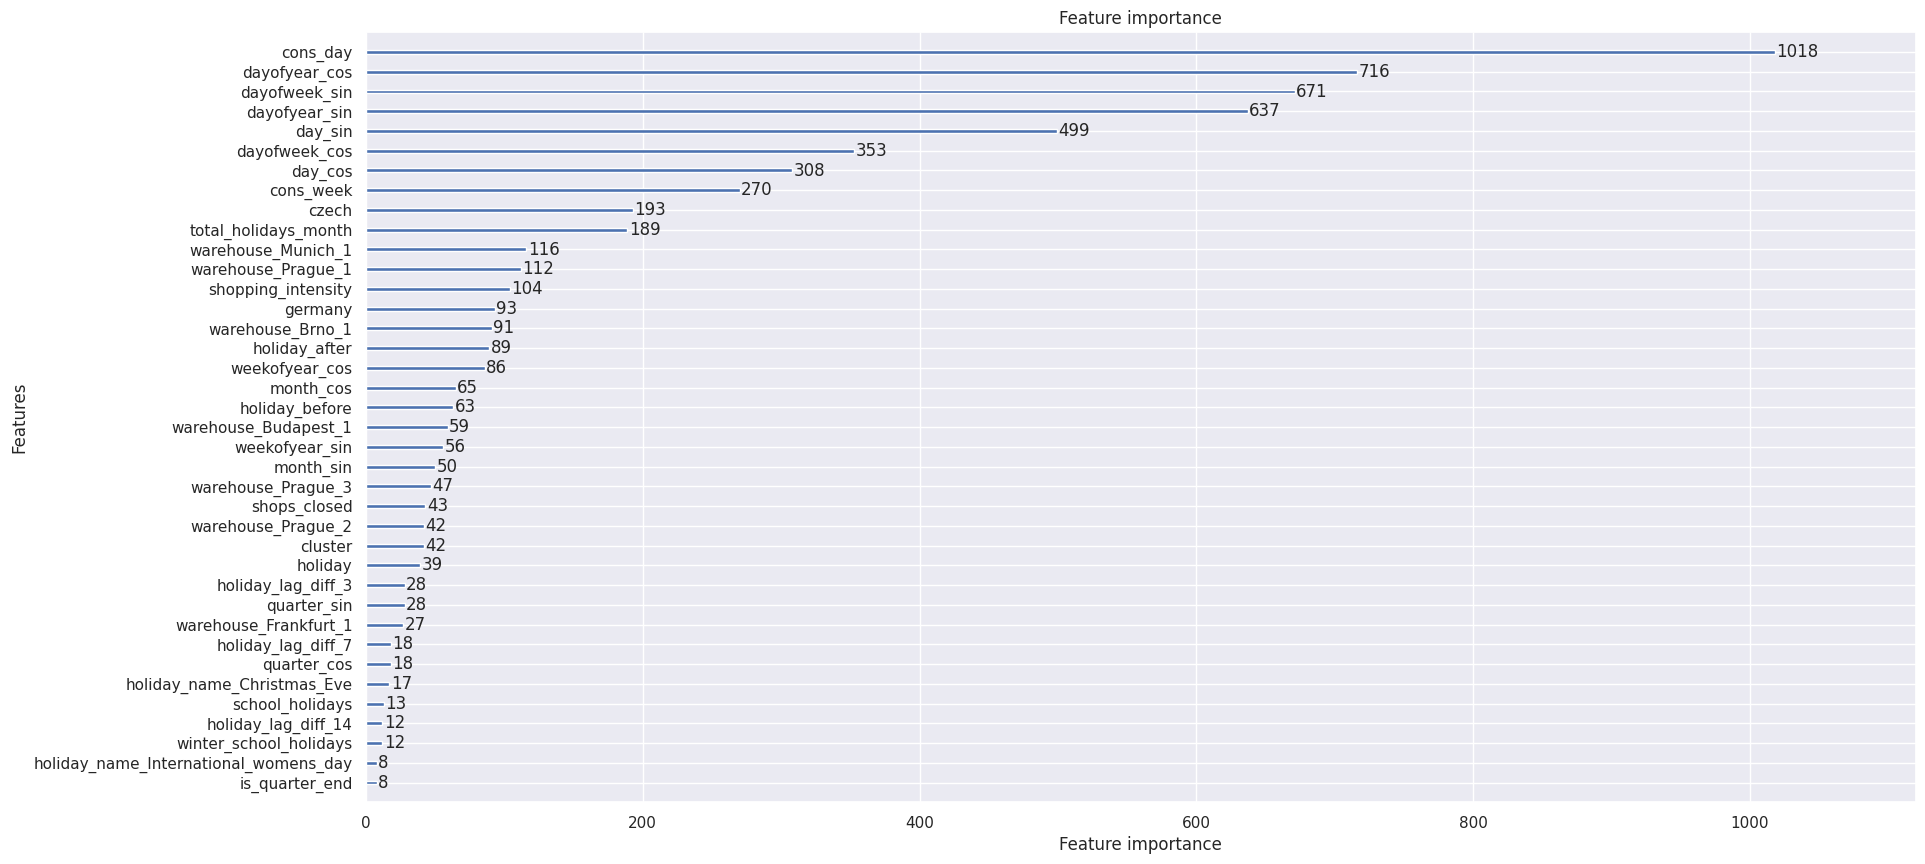

In [32]:
fig, ax = plt.subplots(figsize=(20, 10))
lgb.plot_importance(model, ax=ax)
plt.show()

In [33]:
importances = pd.DataFrame({
    "feature": model.feature_name_,
    "importance": model.feature_importances_
}).sort_values(by="importance", ascending=False)
print(importances[importances["importance"]==0])

                                              feature  importance
25                         holiday_name_New_Years_Day           0
24                     holiday_name_2nd_Christmas_Day           0
27                           holiday_name_Good_Friday           0
45  holiday_name_1848_Revolution_Memorial_Day_(Ext...           0
7                                                year           0
46               holiday_name_All_Saints'_Day_Holiday           0
44  holiday_name_Memorial_Day_for_the_Martyrs_of_Arad           0
28                         holiday_name_Easter_Monday           0
43               holiday_name_Independent_Hungary_Day           0
42                 holiday_name_Day_of_National_Unity           0
41                  holiday_name_National_Defense_Day           0
40  holiday_name_Memorial_Day_for_the_Victims_of_t...           0
39  holiday_name_Memorial_Day_for_the_Victims_of_t...           0
38          holiday_name_Memorial_Day_of_the_Republic           0
37        

In [34]:
print(f"CV scores: {[np.round(i, 4) for i in scores]}")
print(f"CV mean score: {np.mean(scores):.5f}")
print(f"CV CoefVar score: {np.mean(scores)/np.std(scores):.4f}")

CV scores: [0.0488, 0.0404, 0.0426, 0.0375, 0.0378, 0.0393, 0.0386, 0.0346, 0.0343, 0.0358]
CV mean score: 0.03897
CV CoefVar score: 9.5357


In [35]:
wh_scores = {}

df_valid = pd.DataFrame({"orders": label, "preds": oof})

wh_cols = [c for c in df_train.columns if c.startswith("warehouse")]
df_valid["warehouse"] = (wh_ohe.inverse_transform(df_train[wh_cols])).reshape(-1)

for wh in df_valid["warehouse"]:
    wh_scores[f"cv {wh.lower()}"] = mean_absolute_percentage_error(
        df_valid.loc[df_valid["warehouse"] == wh, "orders"], 
        df_valid.loc[df_valid["warehouse"] == wh, "preds"]
    )

print("City CV scores: {}".format({k: np.round(v, 4) for k, v in wh_scores.items()}))

City CV scores: {'cv prague_1': 0.0374, 'cv brno_1': 0.0338, 'cv prague_2': 0.0318, 'cv prague_3': 0.0346, 'cv munich_1': 0.0791, 'cv frankfurt_1': 0.0441, 'cv budapest_1': 0.0278}


In [36]:
run.log({
    "cv mean score": np.mean(scores),
    "cv coefvar score": np.mean(scores)/np.std(scores),
    "folds": FOLDS,
    **wh_scores
})

In [37]:
run.finish()

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:        cv brno_1 ▁
wandb:    cv budapest_1 ▁
wandb: cv coefvar score ▁
wandb:   cv frankfurt_1 ▁
wandb:    cv mean score ▁
wandb:      cv munich_1 ▁
wandb:      cv prague_1 ▁
wandb:      cv prague_2 ▁
wandb:      cv prague_3 ▁
wandb:            folds ▁
wandb: 
wandb: Run summary:
wandb:        cv brno_1 0.03375
wandb:    cv budapest_1 0.02781
wandb: cv coefvar score 9.53572
wandb:   cv frankfurt_1 0.04414
wandb:    cv mean score 0.03897
wandb:      cv munich_1 0.07914
wandb:      cv prague_1 0.03741
wandb:      cv prague_2 0.03181
wandb:      cv prague_3 0.03463
wandb:            folds 10
wandb: 
wandb: 🚀 View run sleek-wind-116 at: https://wandb.ai/diegoib/rohlik-orders/runs/2ot1eu7w
wandb: ⭐️ View project at: https://wandb.ai/diegoib/rohlik-orders
wandb: Synced 5 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-

## **6. Predict & Submission**

In [38]:
preds = np.zeros(df_test.shape[0])

for f in range(FOLDS):
    preds += fitted_models[f].predict(df_test) / FOLDS

In [39]:
df_subm = pd.read_csv(ROOT / "solution_example.csv")
df_subm["orders"] = preds
df_subm.to_csv("submission.csv", index=False)

In [40]:
df_subm.head()

,id,orders
0,Prague_1_2024-03-16,10887.980692
1,Prague_1_2024-03-17,10486.914886
2,Prague_1_2024-03-18,10007.037376
3,Prague_1_2024-03-19,9696.668754
4,Prague_1_2024-03-20,9664.901950


In [41]:
df_subm.describe()

,orders
count,397.000000
mean,6556.389089
std,2505.177678
min,1538.422367
25%,5199.140520
50%,6420.448744
75%,8497.517331
max,11968.128643


## **7. Plot results**

In [42]:
df_train = pd.read_csv(ROOT / "train.csv", parse_dates=["date"])
df_test = pd.read_csv(ROOT / "test.csv", parse_dates=["date"])
df_test["orders"] = preds

all_df = pd.concat([df_train, df_test], axis=0)

In [43]:
cutoff = "2023-03"
all_df = all_df[all_df["date"] > cutoff]

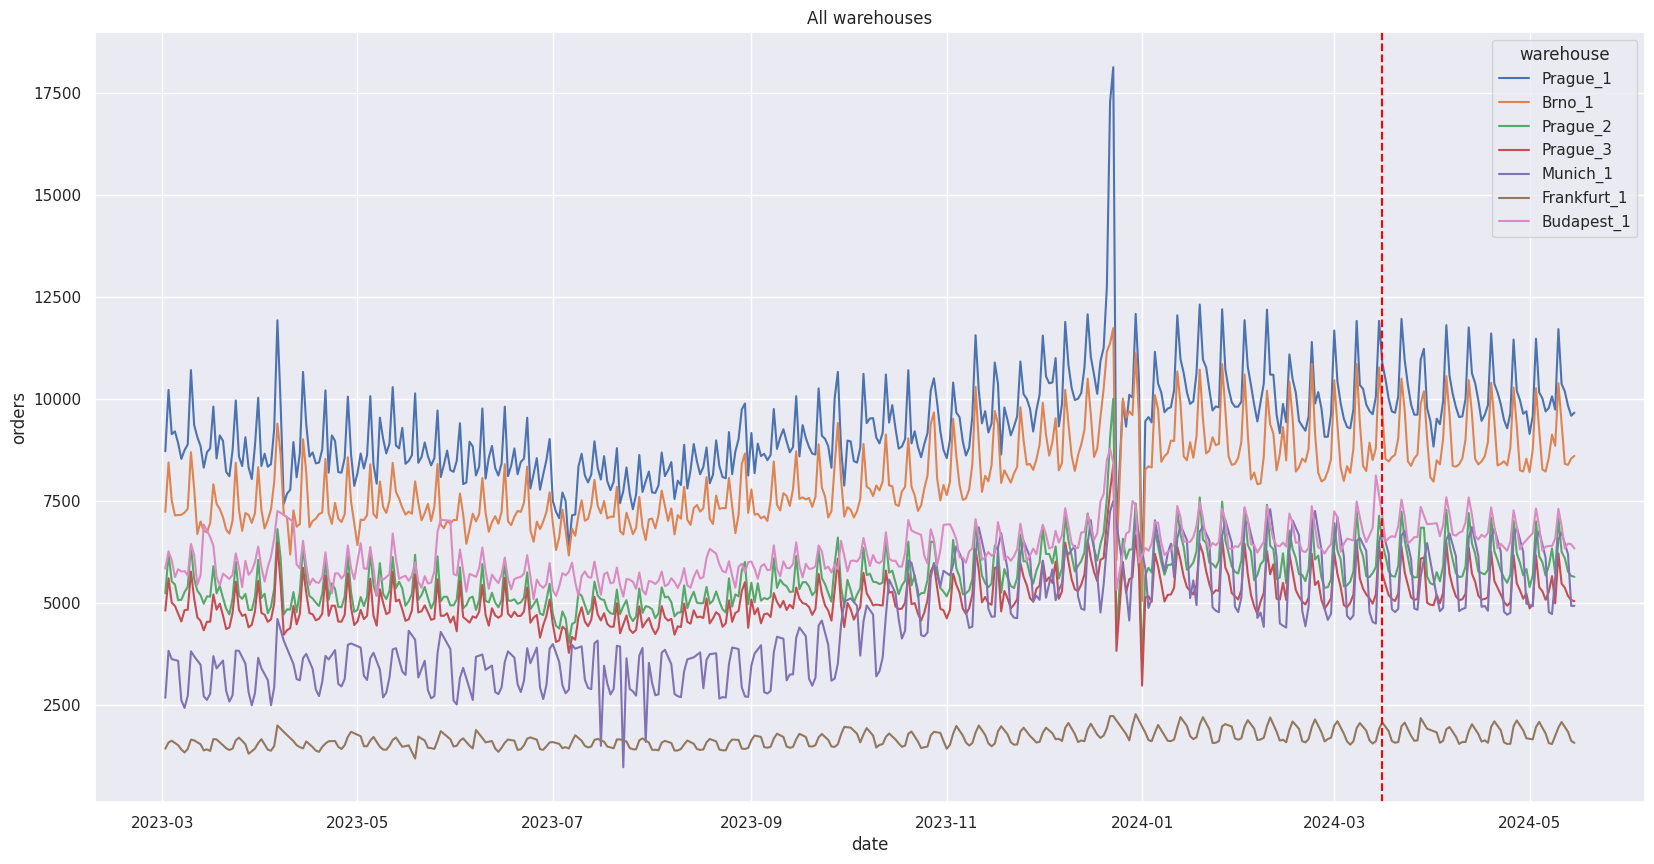

In [44]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.lineplot(
    data=all_df,
    x="date",
    y="orders",
    hue="warehouse",
)
ax.axvline(df_test["date"].min(), ls="--", color="red")
plt.title("All warehouses")
plt.show()